In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MODELPATH = '/content/gdrive/My Drive/Colab Notebooks/yai7_CV1/week3_CAM/modelsave/'

IMAGEWOOFPATH = '/content/gdrive/My Drive/Colab Notebooks/data/imagenette2'

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print("torch version:", torch.__version__)
print("check device:", torch.cuda.get_device_name())
print("how many?:", torch.cuda.device_count())
print("so can i use it?", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch version: 1.7.0+cu101
check device: Tesla T4
how many?: 1
so can i use it? True


In [ ]:
# transformation for CIFAR 10
# yet to implement standard color augmentation

train_transform = transforms.Compose([
                             transforms.Resize(224),
                             transforms.RandomCrop(224, padding=28),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
])

test_transform = transforms.Compose([
                            transforms.Resize(224),
                            transforms.CenterCrop(224),         
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.4963, 0.4612, 0.3981), std=(0.2224, 0.2163, 0.2181))
])

In [ ]:
train_set = torchvision.datasets.ImageFolder(root=IMAGEWOOFPATH+'/train', transform=train_transform)
test_set = torchvision.datasets.ImageFolder(root=IMAGEWOOFPATH+'/val', transform=test_transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

print(f'train_loader {len(train_loader)}')
print(f'test_loader {len(test_loader)}')

train_loader 296
test_loader 118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


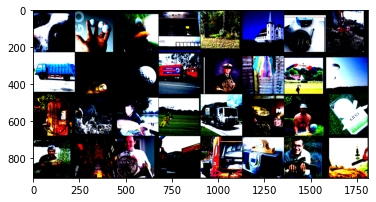

In [ ]:
# check on the images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
# define the basic building blocks for ResNet

# option A
class Padding(nn.Module):
    def __init__(self, in_c, out_c):
        super(Padding, self).__init__()
        self.padding = F.pad
        self.pad_dim = (out_c - in_c) / 2

    def forward(self, x):
        x = self.padding(x, (0,0,0,0, self.pad_dim, self.pad_dim), "constant", 0)
        return x

# option Mine
class Concat(nn.Module):
    def __init__(self, in_c, out_c):
        super(Concat, self).__init__()
        
        self.dim_remainder = (out_c - in_c) % in_c
        self.concat_times = (out_c - in_c) // in_c


    def forward(self, x):

        cat_x = [x] * self.concat_times
        cat_x = torch.cat(cat_x, dim=0)
        cat_x = torch.cat((cat_x, x[:self.dim_remainder]), dim=0)

        return cat_x

class BuildingBlock(nn.Module):

    def __init__(self, in_c, out_c, stride=1, option='B'):
        super(BuildingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.shortcut = nn.Sequential()
        if in_c != out_c:
            if option == 'A':
                self.shortcut = Padding(in_c, out_c)
                # why not concantenate x instead of padding?
                # since dim increase by factor of 2 all the time

            if option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(out_c)
                )
                # i don't like the idea of batchnormalization for projection shortcut
                # should i add BN?
            
            # additional option I thought of hehe
            if option == 'Mine':
                self.shortcut = Concat(in_c, out_c)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [ ]:
class Bottleneck(nn.Module):

    def __init__(self, in_c, process_c, stride=1, option='B'):
        super(Bottleneck, self).__init__()

        self.out_c = process_c * 4

        self.conv1 = nn.Conv2d(in_c, process_c, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(process_c)

        self.conv2 = nn.Conv2d(process_c, process_c, kernel_size=3,
                               stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(process_c)

        self.conv3 = nn.Conv2d(process_c, self.out_c, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(self.out_c)

        self.shortcut = nn.Sequential()
        if in_c != self.out_c:
            if option == 'A':
                self.shortcut = Padding(in_c, self.out_c)
                # why not concantenate x instead of padding?
                # since dim increase by factor of 2 all the time

            if option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_c, self.out_c, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(self.out_c)
                )
                # i don't like the idea of batchnormalization for projection shortcut
                # should i add BN?
            
            # additional option I thought of hehe
            if option == 'Mine':
                self.shortcut = Concat(in_c, self.out_c)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        # slightly changed for CIFAR10
        # in order to have dimension 32x32 --> 16x16
        self.conv_gate = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn_gate = nn.BatchNorm2d(64)
        self.maxpool_gate = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.bn_gate(self.conv_gate(x)))
        x = self.maxpool_gate(x)
        return x

In [ ]:
class ResNet18B(nn.Module):
    def __init__(self):
        super(ResNet18B, self).__init__()

        self.gate = Gate()

        self.conv2_1 = BuildingBlock(64, 64, 1, 'B')
        self.conv2_2 = BuildingBlock(64, 64, 1, 'B')

        self.conv3_1 = BuildingBlock(64, 128, 2, 'B')
        self.conv3_2 = BuildingBlock(128, 128, 1, 'B')

        self.conv4_1 = BuildingBlock(128, 256, 2, 'B')
        self.conv4_2 = BuildingBlock(256, 256, 1, 'B')

        self.conv5_1 = BuildingBlock(256, 512, 1, 'B')
        self.conv5_2 = BuildingBlock(512, 512, 1, 'B')

        self.output = nn.Linear(512, 10)

    def forward(self, x):
        #print("input", x.shape)
        x = self.gate(x)

        #print("1", x.shape)
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        #print("2", x.shape)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        #print("3", x.shape)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        #print("4", x.shape)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        #print("5", x.shape)

        x = F.avg_pool2d(x, 14)
        #print("avgpool", x.shape)

        x = x.view(-1, 512)
        #print("fc", x.shape)

        x = self.output(x)

        return x

In [ ]:
resnet = ResNet18B()
resnet.to(device)

ResNet18B(
  (gate): Gate(
    (conv_gate): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn_gate): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool_gate): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_1): BuildingBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (conv2_2): BuildingBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNor

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #print(m)
        init.kaiming_normal_(m.weight)
        #torch.nn.init.zeros_(m.bias)

    elif isinstance(m, nn.Linear):
        #print(m)
        init.kaiming_normal_(m.weight)
        init.zeros_(m.bias)

    # no initialization for BatchNorm2d

In [ ]:
resnet.apply(weights_init)

ResNet18B(
  (gate): Gate(
    (conv_gate): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn_gate): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool_gate): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_1): BuildingBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (conv2_2): BuildingBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNor

In [ ]:
def train_one_epoch(model, train_loader, loss_function, optimizer, epoch):
    model.train()
    length = len(train_loader)
    running_loss = 0.0

    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        pred = model(image)
        loss = loss_function(pred, label)
    
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 0:
            print(f'after looking at {(i+1)*128} images, running_loss is {running_loss/(i+1):.4f}')

    print(f'epoch {epoch} : loss {running_loss/length:.4f}')


def eval_one_epoch(model, test_loader, epoch):
    model.eval()
    length = len(test_loader)
    running_acc = 0.0

    for i, (image, label) in enumerate(test_loader):
        image, label = image.to(device), label.numpy()

        pred = model(image)
        pred_label = pred.argmax(axis=1).detach().cpu().numpy()
        running_acc += (pred_label==label).mean()

        if i % 50 == 0:
            print(f'after looking at {(i+1)*128} images, running_acc is {running_acc/(i+1):.4f}')

    val_acc = running_acc/length

    print(f'epoch {epoch} : acc {val_acc:.4f}')

    return val_acc

In [ ]:
# hyperparameters from paper
# assuming same for pretraining

learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4
epochs = 100

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=learning_rate, 
                            momentum=momentum, weight_decay=weight_decay)

milestones = [82, 108]

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=milestones, gamma=0.1
)

# 391 iterations per epoch
# 32k iter = 82 epochs
# 42k iter = 108 epochs
# 64k iter = 164 epochs

In [ ]:
val_acc_list = []
best_val_acc = 0

for epoch in range(epochs):
    train_one_epoch(resnet, train_loader, loss_function, optimizer, epoch)
    val_acc = eval_one_epoch(resnet, test_loader, epoch)
    val_acc_list.append(val_acc)

    scheduler.step()

    if val_acc > best_val_acc:
        print("### saving current model...### \n")
        torch.save(resnet.state_dict(), MODELPATH+f'woof_RestNet18B')
        best_val_acc = val_acc

after looking at 128 images, running_loss is 2.9374
after looking at 6528 images, running_loss is 2.4370
after looking at 12928 images, running_loss is 2.2997
after looking at 19328 images, running_loss is 2.1345
after looking at 25728 images, running_loss is 2.0104
after looking at 32128 images, running_loss is 1.9107
epoch 0 : loss 1.8473
after looking at 128 images, running_acc is 0.1250
after looking at 6528 images, running_acc is 0.2353
after looking at 12928 images, running_acc is 0.3524
epoch 0 : acc 0.3926
### saving current model...### 

after looking at 128 images, running_loss is 2.2906
after looking at 6528 images, running_loss is 1.4268
after looking at 12928 images, running_loss is 1.3910
after looking at 19328 images, running_loss is 1.3608
after looking at 25728 images, running_loss is 1.3433
after looking at 32128 images, running_loss is 1.3260
epoch 1 : loss 1.3161
after looking at 128 images, running_acc is 0.7812
after looking at 6528 images, running_acc is 0.5239
a

In [ ]:
val_acc_list

[0.3925965160075329,
 0.5485522598870057,
 0.5640889830508474,
 0.598781779661017,
 0.6841749058380414,
 0.6958274482109228,
 0.763771186440678,
 0.7301377118644068,
 0.779396186440678,
 0.7727754237288136,
 0.7530308380414312,
 0.7983168549905838,
 0.78125,
 0.806261770244821,
 0.8082627118644068,
 0.7803083804143126,
 0.8291843220338984,
 0.785722693032015,
 0.7944915254237288,
 0.7976694915254238,
 0.8247999058380414,
 0.828125,
 0.8081155838041431,
 0.8255943973634652,
 0.8268008474576272,
 0.8461040489642184,
 0.8359227871939736,
 0.835657956685499,
 0.8188559322033898,
 0.8245350753295668,
 0.8254766949152542,
 0.8454566854990584,
 0.8395127118644068,
 0.8397775423728814,
 0.8270362523540489,
 0.8526071092278719,
 0.8433086158192091,
 0.8509004237288136,
 0.8372469397363465,
 0.8434851694915254,
 0.8473104990583804,
 0.8358050847457628,
 0.8714100753295668,
 0.8293020244821092,
 0.8433380414312618,
 0.8249176082862523,
 0.8454566854990584,
 0.8653189736346516,
 0.8528719397363465